Installing dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install fastText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing required libraries

In [3]:
import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import string
import random
import logging
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow import random
from keras import regularizers
tf.random.set_seed(1)

<ipython-input-3-48eeef18465f>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [4]:
import fasttext
import fasttext.util
# fasttext.util.download_model('kn', if_exists = 'ignore') 
tf.random.set_seed(1)
ft = fasttext.load_model('/content/drive/MyDrive/FND_Kannada/data/fasttext_modules/cc.kn.300.bin')

Pre-processing data

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/FND_Kannada/data/v2/train.csv')
df_train.head()

,news,source,label
0,ಈ ವ್ಯಕ್ತಿ ಪ್ರೌಢಶಾಲೆಯಲ್ಲಿ 26 ಬಾರಿ ಫೇಲ್ ಆಗಿದ್ದಾನೆ,oneindia,0
1,ಸರ್ಕಾರದ ಜೊತೆ ಉದ್ಧವ್ ಠಾಕ್ರೆಯ ಪಕ್ಷವನ್ನೂ ವಶಪಡಿಸ್ಕ...,asianet,1
2,ಹುಲಿ ಸಂರಕ್ಷಿತ ಪ್ರದೇಶ ಘೋಷಣೆ ಸಿಎಂ ನಿರ್ಧಾರಕ್ಕೆ ಉಮ...,prajavani,1
3,108 ಗಂಟೆಯಲ್ಲಿ 75 ಕಿಮೀ ರಸ್ತೆ ನಿರ್ಮಾಣದ ಗುರಿ ಗಿನ್...,asianet,1
4,ಬಾಳಾಠಾಕ್ರೆ ತಿಲಕ ಇಡುತ್ತಿರುವುದು ಏಕನಾಥ್ ಶಿಂಧೆಗಲ್...,asianet,0


In [6]:
df_test = pd.read_csv('/content/drive/MyDrive/FND_Kannada/data/v2/test.csv')
df_test.head()

,news,source,label
0,ನಿರಂತರ ಮಳೆ: ಕೊಳೆತ ಉದ್ದು ಬೆಳೆ ...,prajavani,1
1,ಸಲಿಂಗ ಸಂಬಂಧ ವಿರೋಧಿಸಿದ್ದಕ್ಕೆ ಲಿಂಗ ಬದಲಿಸಿಕೊಂಡಳು,asianet,1
2,ನ್ಯೂಯಾರ್ಕ್ ಟೈಮ್ಸ್‌ ಮುಖಪುಟದಲ್ಲಿ ಮೋದಿ ಬಗ್ಗೆ ವರದ...,oneindia,0
3,ಡ್ರೋಣ್ ಬಾಯ್ ಪ್ರತಾಪ್‌ನನ್ನು ವಿಜ್ಞಾನಿಯಾಗಿ DRDOಗೆ ...,factly,0
4,"ಎಸ್ಎಂಕೆ, ನಾರಾಯಣ ಮೂರ್ತಿ, ಪ್ರಕಾಶ್ ಪಡುಕೋಣೆಗೆ ಕೆಂಪ...",asianet,1


In [7]:
y_train = to_categorical(df_train.label.values)
y_test = to_categorical(df_test.label.values)

In [8]:
df_train.dtypes

news      object
source    object
label      int64
dtype: object

In [9]:
maxi = -1
for i, rev in enumerate(df_train['news']):
    rev = str(rev)
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)
print(maxi)

20


In [10]:
df_train['news'] = df_train.news.astype(str)
df_test['news'] = df_test.news.astype(str)

In [11]:
#tokenizing the text
tf.random.set_seed(1)
tokenizer = Tokenizer()
df_total = pd.concat([df_train['news'], df_test.news], axis = 0)
tokenizer.fit_on_texts(df_total)

In [12]:
max_rev_len = maxi
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 300

In [13]:
print(len(tokenizer.word_index))

10652


In [14]:
#padding the tokenized text
tf.random.set_seed(1)
X_train = tokenizer.texts_to_sequences(df_train['news'])  
X_train_pad = pad_sequences(X_train, maxlen = max_rev_len, padding = 'post')  
X_test = tokenizer.texts_to_sequences(df_test.news)
X_test_pad = pad_sequences(X_test, maxlen = max_rev_len, padding = 'post')

In [15]:
#creating the embedding matrix
tf.random.set_seed(1)
embed_matrix = np.zeros(shape = (vocab_size, embed_dim))
for word, i in tokenizer.word_index.items():
  embed_vector = ft.get_word_vector(word)
  if embed_vector is not None:  
    embed_matrix[i] = embed_vector
embed_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01565978, -0.17180113,  0.05220554, ..., -0.01711703,
        -0.04263768,  0.07200605],
       [-0.03468504, -0.03964358,  0.00743476, ..., -0.01015441,
         0.00036771,  0.05935644],
       ...,
       [-0.00293929, -0.0238599 ,  0.0079745 , ..., -0.01249184,
        -0.02368815, -0.01550001],
       [ 0.12727913, -0.05234719, -0.19674143, ...,  0.1489598 ,
        -0.1010747 ,  0.10291557],
       [ 0.03885119, -0.09218641, -0.02062478, ...,  0.02812324,
         0.02520905,  0.02904611]])

In [16]:
#training params
batch_size = 64
num_epochs = 100

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

Training the data on the model

In [67]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length = max_rev_len, weights = [embed_matrix], trainable = True))
model.add(Conv1D(num_filters, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling1D())
model.add(Conv1D(num_filters, 3, activation = 'relu', padding = 'same'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax')) 
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 300)           3195900   
                                                                 
 conv1d_10 (Conv1D)          (None, 20, 64)            57664     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 64)            12352     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 flatten_1 (Flatten)         (None, 64)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
#saving weights of the best model
tf.random.set_seed(1)
checkpoint_filepath = '/content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/fasttext+cnn.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [69]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 5)

In [70]:
#model training
tf.random.set_seed(1)
history_embedding = model.fit(X_train_pad, y_train, batch_size = 64, epochs = num_epochs, callbacks = [model_checkpoint_callback, early_stopping_callback], validation_split = 0.1, shuffle = True, verbose = 2)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.85217, saving model to /content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/fasttext+cnn.hdf5
33/33 - 4s - loss: 0.5056 - accuracy: 0.7580 - val_loss: 0.3422 - val_accuracy: 0.8522 - 4s/epoch - 127ms/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.85217
33/33 - 2s - loss: 0.0874 - accuracy: 0.9705 - val_loss: 0.9100 - val_accuracy: 0.8043 - 2s/epoch - 61ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.85217
33/33 - 3s - loss: 0.0306 - accuracy: 0.9952 - val_loss: 1.7830 - val_accuracy: 0.8087 - 3s/epoch - 99ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.85217
33/33 - 3s - loss: 0.0093 - accuracy: 0.9976 - val_loss: 2.2165 - val_accuracy: 0.8304 - 3s/epoch - 79ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.85217
33/33 - 3s - loss: 0.0076 - accuracy: 0.9990 - val_loss: 2.9423 - val_accuracy: 0.8304 - 3s/epoch - 77ms/step
Epoch 6/100

Epoch 6: val_accuracy did

Visualizing the training and validation results

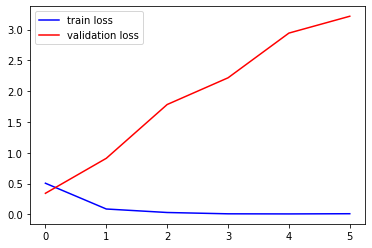

In [71]:
plt.plot(history_embedding.history['loss'], c = 'b', label = 'train loss')
plt.plot(history_embedding.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

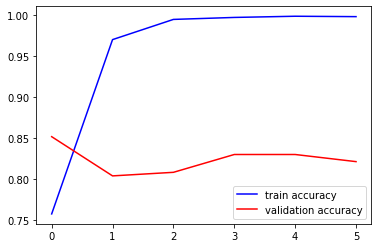

In [72]:
plt.plot(history_embedding.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history_embedding.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc='lower right')
plt.show()

Extracting classification report and confusion matrix

In [73]:
tf.random.set_seed(1)

In [74]:
y_pred = np.argmax(model.predict(X_test_pad), axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred))

16/16 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.86      0.65      0.74       200
           1       0.80      0.93      0.86       300

    accuracy                           0.82       500
   macro avg       0.83      0.79      0.80       500
weighted avg       0.82      0.82      0.81       500



In [75]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[129  71]
 [ 21 279]]


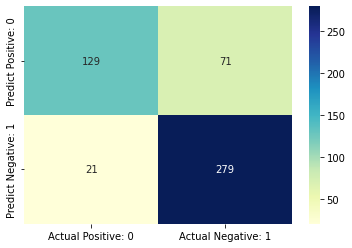

In [76]:
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive: 0', 'Actual Negative: 1'], index = ['Predict Positive: 0', 'Predict Negative: 1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')